In [ ]:
#import delle librerie
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
import random
from tqdm import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
from keras import backend as K
import gc

In [ ]:
#download del dataset
!git clone https://github.com/EdoardoGit/ML_Colab.git

Cloning into 'ML_Colab'...
remote: Enumerating objects: 24980, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 24980 (delta 0), reused 6 (delta 0), pack-reused 24974
Receiving objects: 100% (24980/24980), 895.68 MiB | 21.47 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (25003/25003), done.


In [ ]:
#definizione delle costanti
CATEGORIE = ("Dogs/","Cats/")
DIR='/content/ML_Colab/CatsDogs/'
IMG_SIZE = 75
OUTPUT_LOSS_PATH="output_loss_fold"
OUTPUT_VAL_PATH="output_val_fold"
OUTPUT_CONF_PATH="output_conf_fold"
OUTPUT_MEAN_LOSS_PATH="output_mean_loss"
OUTPUT_MEAN_ACC_PATH="output_mean_acc"
OUTPUT_MEAN_CONF_PATH="output_mean_conf"
EARLY_STOP_PATIENCE=5

In [ ]:
n_splits=5
n_epochs=20
n_batch=32

In [ ]:
#costruisco il dataset con IMG(gray),label
def create_training_data():
  training_data = []
  for categories in CATEGORIE:
    path = os.path.join(DIR,categories)
    print(path)
    class_num = CATEGORIE.index(categories)
    for image in tqdm(os.listdir(path)):
      try:
        img_array = cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
        #print(img_array.shape)
        #if img_array is None:
        #  print('Wrong path:', os.path.join(path,image))
        #else:
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

        training_data.append([new_array,class_num])
      except Exception as e:
        #print(e)
        pass
  return training_data

In [ ]:
data=create_training_data()
print(len(data))

/content/ML_Colab/CatsDogs/Dogs/


100%|██████████| 12500/12500 [00:17<00:00, 721.30it/s]


/content/ML_Colab/CatsDogs/Cats/


100%|██████████| 12500/12500 [00:17<00:00, 719.08it/s]

24946


In [ ]:
#mischio i dati
random.shuffle(data)

In [ ]:
#suddivido i dati in inputs(X) e outputs(y)
def data_construct(data):
  input=[]
  output=[]

  for img,label in data:
    input.append(img)
    y=np.zeros(len(CATEGORIE))
    y[label]=1
    output.append(y)
  input=np.array(input).reshape(-1,IMG_SIZE,IMG_SIZE)
  return input,output

In [ ]:
X,y = data_construct(data)

In [ ]:
#check della shape di X
print('images shape:', X.shape)

images shape: (24946, 75, 75)


In [ ]:
#check di un valore di y
print('labels example:', y[0])

labels example: [0. 1.]


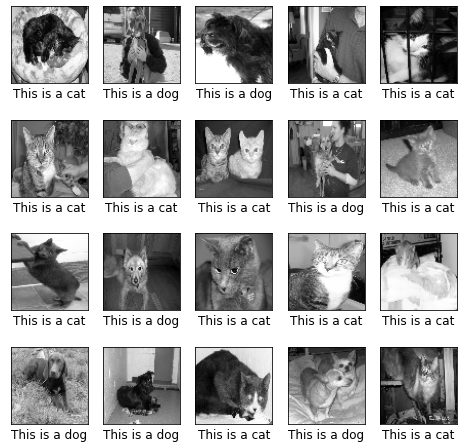

In [ ]:
#check dei primi 20 campioni
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i], cmap='gray')
    plt.xlabel(f'This is a {"dog" if y[i][0] == 1 else "cat"}', size=12)
plt.savefig('grid_example')
plt.show()

In [ ]:
#converto e normalizzo X
X=np.asarray(X)
y=np.asarray(y)
X = X/ 255

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare le loss delle fold
def save_loss_plot(H,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"],label="train_loss")
  #plt.plot(H.history["val_loss"],label="val_loss")
  #plt.plot(H.history["categorical_accuracy"],label="train_acc")
  plt.plot(H.history["custom_zero_loss"],label="0-1_loss")
  #plt.plot(H.history["val_categorical_accuracy"],label="val_acc")
  plt.plot(H.history["val_custom_zero_loss"],label="val_0-1_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Train Loss and 0-1 Loss")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare le accuracy delle fold
def save_val_plot(H,path):
  plt.style.use("ggplot")
  plt.figure()
  #plt.plot(H.history["loss"],label="train_loss")
  #plt.plot(H.history["val_loss"],label="val_loss")
  plt.plot(H.history["categorical_accuracy"],label="train_acc")
  plt.plot(H.history["val_categorical_accuracy"],label="val_acc")
  #plt.plot(H.history["val_custom_zero_loss"],label="val_loss")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Accuracy")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la confusion matrix delle fold
def save_conf_plot(y_true,y_pred,path):
  #converto gli array da (p,1-p) a (0/1)
  ypred_s=[]
  for data_pred in y_pred:
    if data_pred[0]>0.5:
      ypred_s.append(1)
    else:
      ypred_s.append(0)
  
  ytrue_s=[]
  for y_t in y_true:
    ytrue_s.append(int(y_t[0]))

  plt.figure()
  cfm = confusion_matrix(ytrue_s, ypred_s)
  print(cfm)
  ax= plt.subplot()
  sns.heatmap(cfm, annot=True, ax = ax, fmt='g');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['cats', 'dogs'])
  ax.yaxis.set_ticklabels(['cats', 'dogs'])
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la confusion matrix media
def save_mean_conf_plot(y_true,y_pred,path):
  #converto gli array da (p,1-p) a (0/1)
  ypred_s=[]
  for data_pred in y_pred:
    if data_pred[0]>0.5:
      ypred_s.append(1)
    else:
      ypred_s.append(0)
  
  ytrue_s=[]
  for y_t in y_true:
    ytrue_s.append(int(y_t[0]))

  plt.figure()
  cfm = confusion_matrix(ytrue_s, ypred_s)
  cfm=cfm/n_splits
  print(cfm)
  ax= plt.subplot()
  sns.heatmap(cfm, annot=True, ax = ax, fmt='g');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['cats', 'dogs'])
  ax.yaxis.set_ticklabels(['cats', 'dogs'])
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la loss media
def save_mean_loss_plot(mloss,mozloss,meanvalozloss,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(mloss,label="train_loss")
  plt.plot(mozloss,label="train_0-1_loss")
  plt.plot(meanvalozloss,label="val_0-1_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Loss")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la accuracy media
def save_mean_acc_plot(macc,mvalacc,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(macc,label="train_acc")
  plt.plot(mvalacc,label="val_acc")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Accuracy")
  plt.legend()
  plt.savefig(path)

In [ ]:
#definisco la variabile per la custom metric
m=tf.keras.metrics.CategoricalAccuracy()

In [ ]:
#definisco la custom metric (zero-one loss)
def custom_zero_loss(y_true, y_pred):
  m.reset_state()
  m.update_state(y_true,y_pred)
  return 1-m.result()

STANDARD 2 HIDDEN LAYERS

In [ ]:
#definisco l'architettura (STANDARD 2 HIDDEN LAYERS)
def model_builder():
  model = Sequential()

  #input layer
  model.add(Flatten(input_shape=(75,75)))

  #hidden layers
  model.add(Dense(64, activation="relu"))
  model.add(Dense(64, activation="relu"))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#print delle folds (ESEGUIRE SOLO PER LA STAMPA)
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 4990  4991  4992 ... 24943 24944 24945] TEST: [   0    1    2 ... 4987 4988 4989]
TRAIN: [    0     1     2 ... 24943 24944 24945] TEST: [4990 4991 4992 ... 9976 9977 9978]
TRAIN: [    0     1     2 ... 24943 24944 24945] TEST: [ 9979  9980  9981 ... 14965 14966 14967]
TRAIN: [    0     1     2 ... 24943 24944 24945] TEST: [14968 14969 14970 ... 19954 19955 19956]
TRAIN: [    0     1     2 ... 19954 19955 19956] TEST: [19957 19958 19959 ... 24943 24944 24945]


In [ ]:
#definisco training e crossvalidation

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #genero le splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #instance del modello
    model = model_builder()

    #fit del modello + grafici
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/20
624/624 [==============================] - 5s 6ms/step - loss: 0.6983 - categorical_accuracy: 0.5492 - custom_zero_loss: 0.4508 - val_loss: 0.6796 - val_categorical_accuracy: 0.5489 - val_custom_zero_loss: 0.4511
Epoch 2/20
624/624 [==============================] - 3s 5ms/step - loss: 0.6762 - categorical_accuracy: 0.5744 - custom_zero_loss: 0.4255 - val_loss: 0.6706 - val_categorical_accuracy: 0.5996 - val_custom_zero_loss: 0.4004
Epoch 3/20
624/624 [==============================] - 5s 7ms/step - loss: 0.6717 - categorical_accuracy: 0.5835 - custom_zero_loss: 0.4165 - val_loss: 0.6757 - val_categorical_accuracy: 0.5677 - val_custom_zero_loss: 0.4322
Epoch 4/20
624/624 [==============================] - 4s 6ms/step - loss: 0.6685 - categorical_accuracy: 0.5896 - custom_zero_loss: 0.4103 - val_loss: 0.6643 - val_categorical_accuracy: 0.5890 - val_custom_zero_loss: 0.4110
Epoch 5/20
624/624 [==============================] - 3s 5ms/step - loss: 0.6656 - categoric

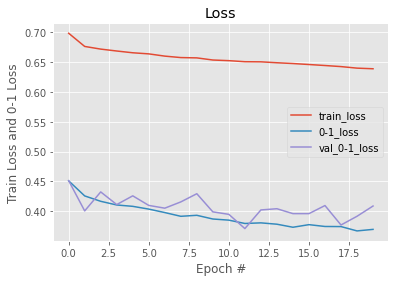

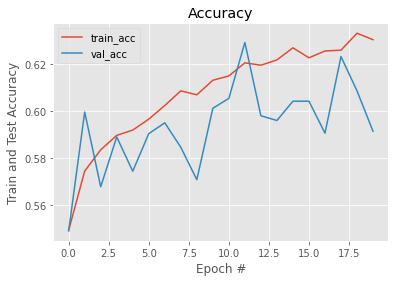

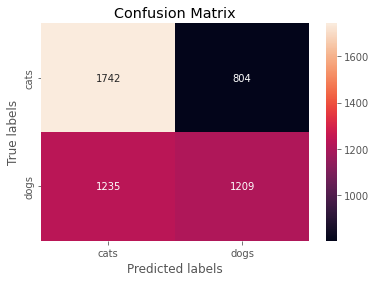

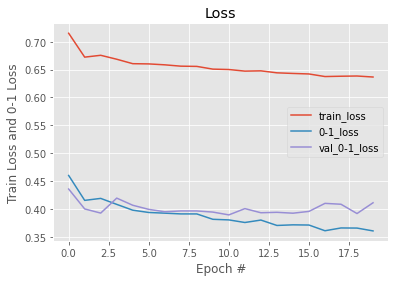

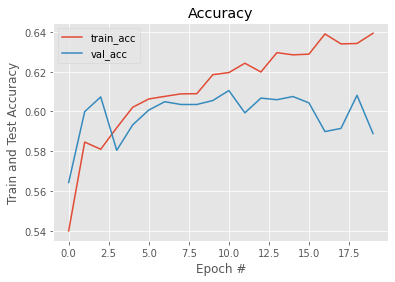

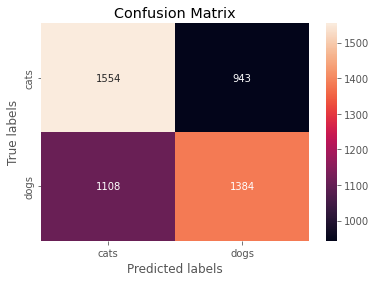

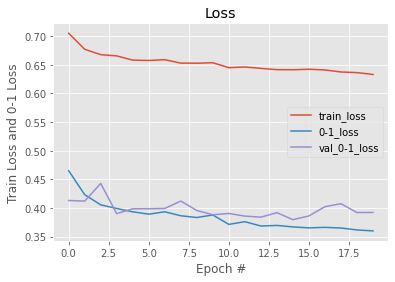

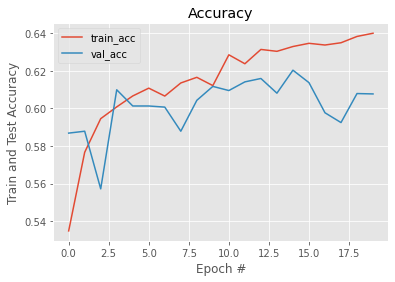

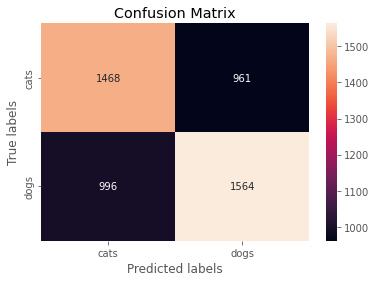

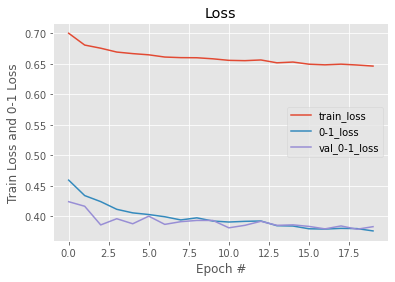

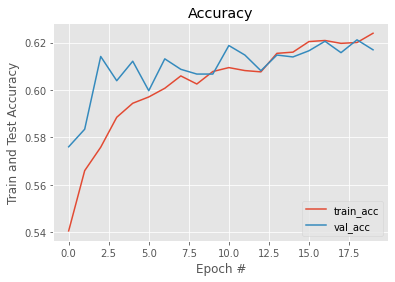

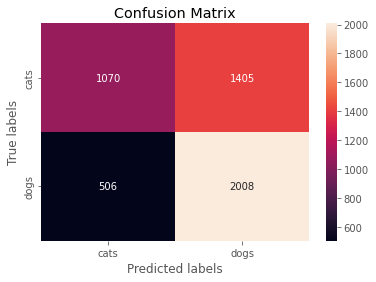

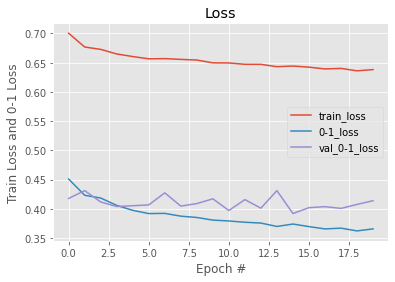

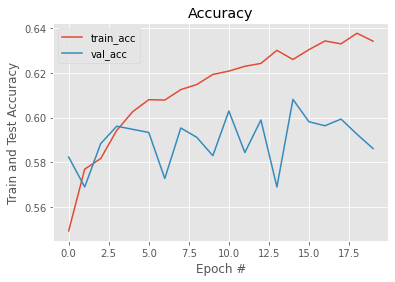

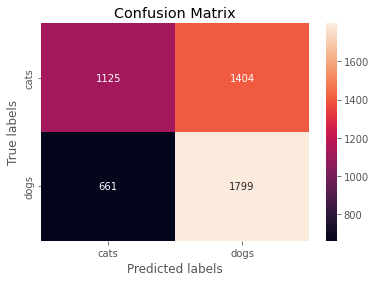

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6641467213630676 - Accuracy: 0.5913827419281006% - Zero-One N Loss: 2039 - Zero-One Loss: 0.40861723446893783%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.687013566493988 - Accuracy: 0.5888955593109131% - Zero-One N Loss: 2051 - Zero-One Loss: 0.4111044297454399%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6553612351417542 - Accuracy: 0.6077370047569275% - Zero-One N Loss: 1957 - Zero-One Loss: 0.3922629785528162%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6567394137382507 - Accuracy: 0.6169573068618774% - Zero-One N Loss: 1911 - Zero-One Loss: 0.3830426939266386%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6736499667167664 - Accuracy: 0.5860893726348877% - Zero-One N Loss: 2065 - Zero-One L

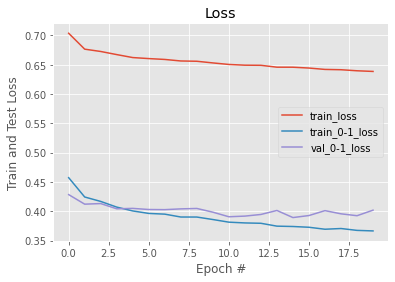

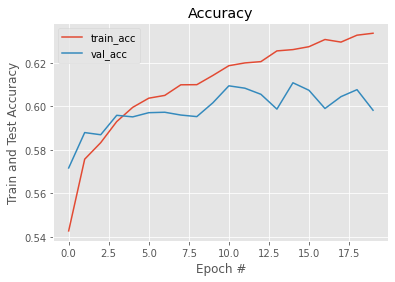

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
for h_loss in histories:
  mean_loss = np.add(mean_loss,h_loss.history["loss"])
  mean_oz_loss = np.add(mean_oz_loss,h_loss.history["custom_zero_loss"])
  mean_val_oz_loss = np.add(mean_val_oz_loss,h_loss.history["val_custom_zero_loss"])
  mean_acc= np.add(mean_acc,h_loss.history["categorical_accuracy"])
  mean_val_acc = np.add(mean_val_acc,h_loss.history["val_categorical_accuracy"])
mean_loss=mean_loss/n_splits
mean_oz_loss=mean_oz_loss/n_splits
mean_val_oz_loss=mean_val_oz_loss/n_splits
mean_acc=mean_acc/n_splits
mean_val_acc=mean_val_acc/n_splits

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[1391.8 1103.4]
 [ 901.2 1592.8]]


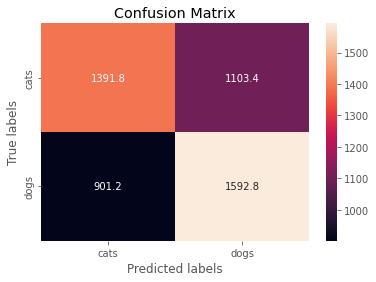

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

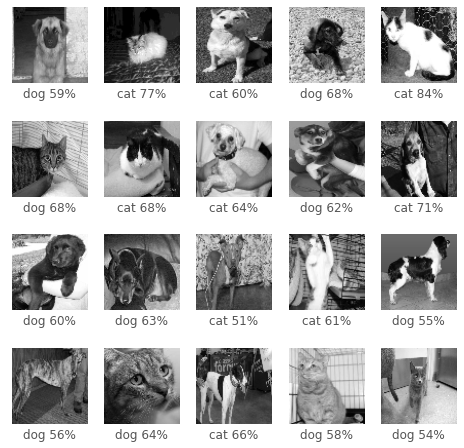

In [ ]:
#[0 1]-> cat,[1 0]->dog
#visualizzo i risultati della prima fold
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

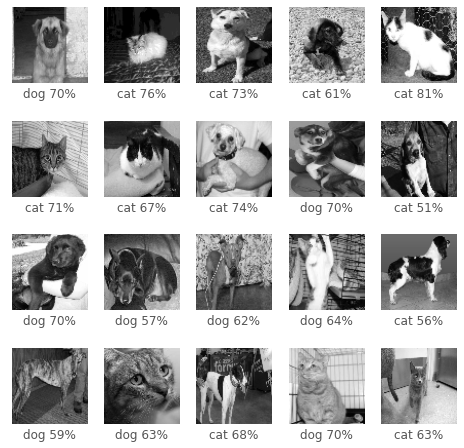

In [ ]:
#[0 1]-> cat,[1 0]->dog
#visualizzo i risultati della seconda fold
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()



HYPERTUNING 2 HIDDEN LAYER

In [ ]:
#definisco l'early stopping per il tuning
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.4 MB/s eta 0:00:00


In [ ]:
#definisco l'architettura (HYP_TUNING 2 DENSE LAYER)
def model_builder(hp):
  model = Sequential()

  #input layer
  model.add(Flatten(input_shape=(75, 75)))

  #hidden layers
  hp_units=hp.Int('num_of_neurons_l1',min_value=16,max_value=512,step=16)
  model.add(Dense(units=hp_units,activation='relu'))
  hp_units=hp.Int('num_of_neurons_l2',min_value=16,max_value=512,step=16)
  model.add(Dense(units=hp_units,activation='relu'))

  #output layer
  model.add(Dense(2,activation='softmax'))
  
  model.compile (
	loss = "categorical_crossentropy",
	optimizer =keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-3,1e-4])),
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#costruisco il tuner
from keras_tuner import BayesianOptimization

tuner=BayesianOptimization(
    model_builder,
    objective='val_categorical_accuracy',
    max_trials=10,
    directory='turner1',
    project_name='ML')

tuner.search_space_summary()

Search space summary
Default search space size: 3
num_of_neurons_l1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': 'linear'}
num_of_neurons_l2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
#definisco i parametri del tuner
n_epochs=20

tuner.search(
    x=X,
    y=y,
    validation_split=0.2,
    callbacks=[stop_early],
    epochs=n_epochs
)

bestHP=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of neurons in first layer: {}".format(bestHP.get('num_of_neurons_l1')))
print("[INFO] optimal number of neurons in second layer: {}".format(bestHP.get('num_of_neurons_l2')))
print("[INFO] optimal learning rate: {}".format(bestHP.get("learning_rate")))
#print("[INFO] optimal batch size: {}".format(
#    bestHP.get("batch_size")))

Trial 10 Complete [00h 04m 56s]
val_categorical_accuracy: 0.64368736743927

Best val_categorical_accuracy So Far: 0.6494989991188049
Total elapsed time: 00h 54m 57s
[INFO] optimal number of neurons in first layer: 240
[INFO] optimal number of neurons in second layer: 368
[INFO] optimal learning rate: 0.0001


In [ ]:
#definisco l'early stopping per il training
stop_early=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_batch=32

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #genero le splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #instance del modello
    model=tuner.hypermodel.build(bestHP)

    #fit del modello + grafici
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/20
624/624 [==============================] - 19s 29ms/step - loss: 0.6774 - categorical_accuracy: 0.5682 - custom_zero_loss: 0.4319 - val_loss: 0.6775 - val_categorical_accuracy: 0.5782 - val_custom_zero_loss: 0.4219
Epoch 2/20
624/624 [==============================] - 16s 26ms/step - loss: 0.6614 - categorical_accuracy: 0.6014 - custom_zero_loss: 0.3987 - val_loss: 0.6654 - val_categorical_accuracy: 0.5940 - val_custom_zero_loss: 0.4061
Epoch 3/20
624/624 [==============================] - 16s 26ms/step - loss: 0.6577 - categorical_accuracy: 0.6103 - custom_zero_loss: 0.3897 - val_loss: 0.6720 - val_categorical_accuracy: 0.5944 - val_custom_zero_loss: 0.4056
Epoch 4/20
624/624 [==============================] - 16s 26ms/step - loss: 0.6500 - categorical_accuracy: 0.6199 - custom_zero_loss: 0.3802 - val_loss: 0.6871 - val_categorical_accuracy: 0.5868 - val_custom_zero_loss: 0.4133
Epoch 5/20
624/624 [==============================] - 17s 28ms/step - loss: 0.6455 -

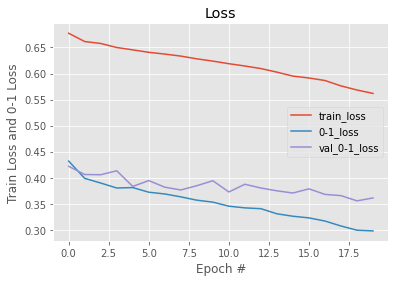

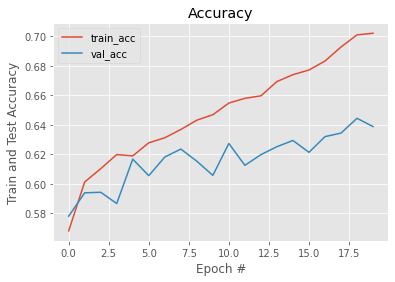

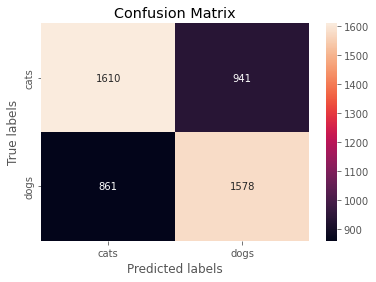

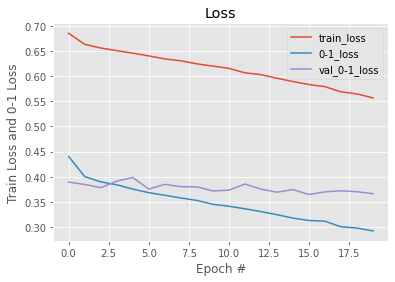

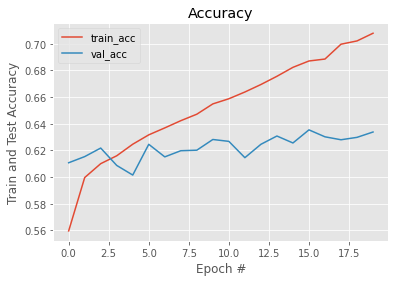

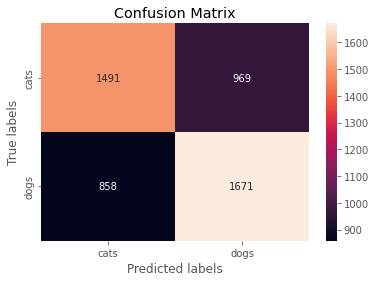

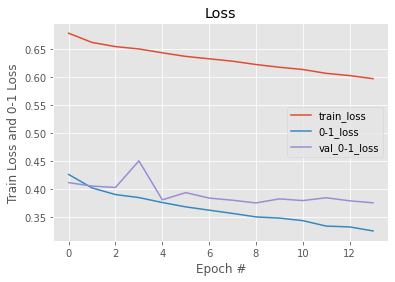

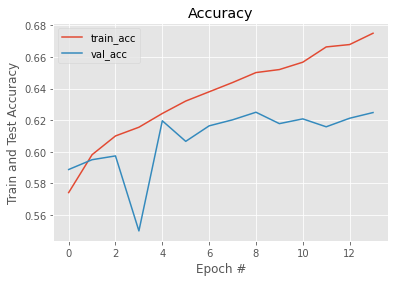

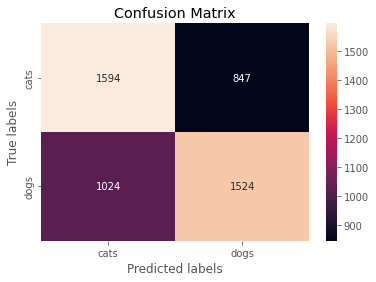

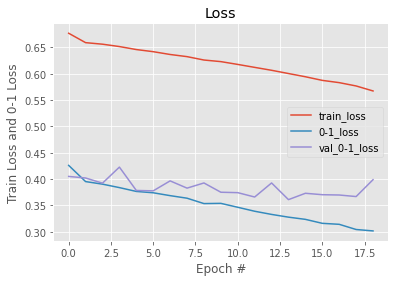

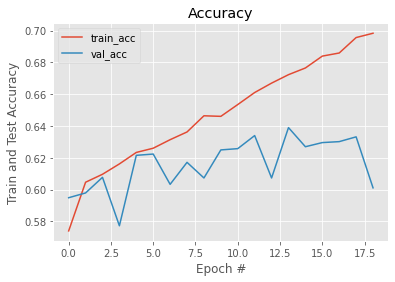

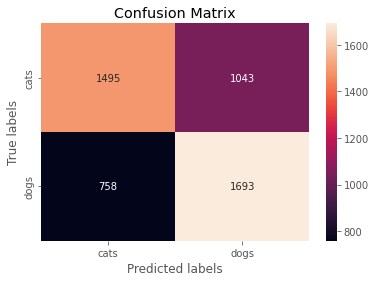

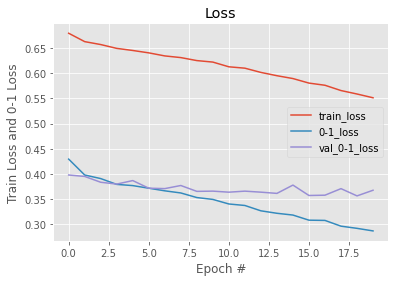

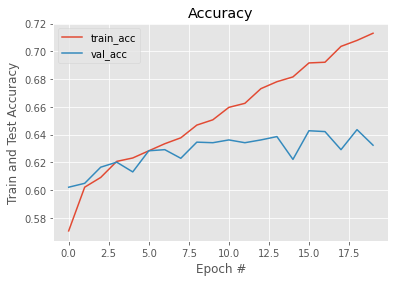

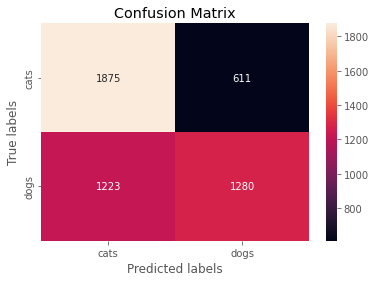

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]} - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)} (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)} (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6413754224777222 - Accuracy: 0.6388777494430542 - Zero-One N Loss: 1802 - Zero-One Loss: 0.361122244488978
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6541816592216492 - Accuracy: 0.633794367313385 - Zero-One N Loss: 1827 - Zero-One Loss: 0.36620565243535774
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6469125151634216 - Accuracy: 0.6249749660491943 - Zero-One N Loss: 1871 - Zero-One Loss: 0.3750250551212668
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6371978521347046 - Accuracy: 0.6390058398246765 - Zero-One N Loss: 1801 - Zero-One Loss: 0.36099418721186616
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6660495400428772 - Accuracy: 0.6323912739753723 - Zero-One N Loss: 1834 - Zero-One Loss: 0.36

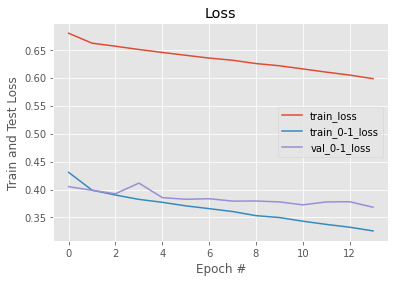

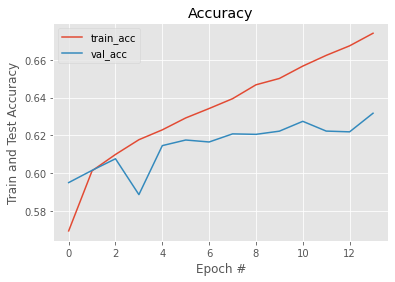

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(20,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(20,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(20,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(20,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(20,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[1613.   882.2]
 [ 944.8 1549.2]]


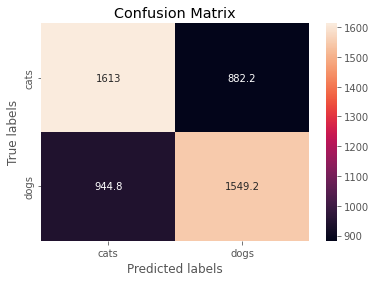

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

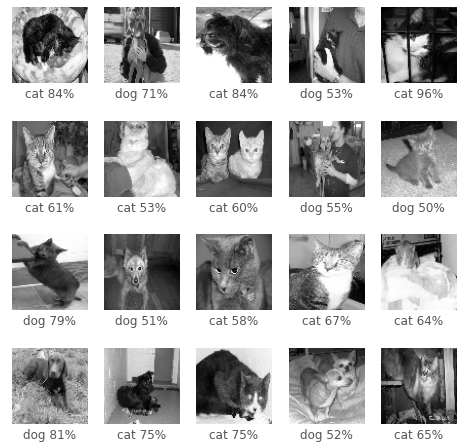

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

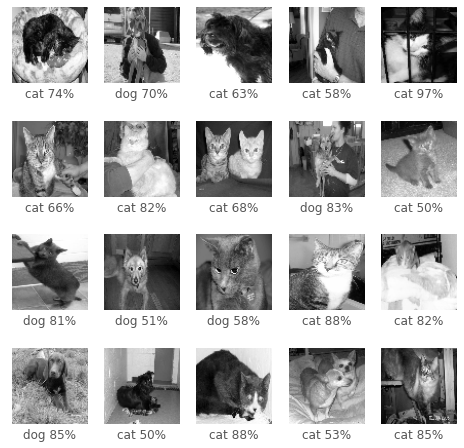

In [ ]:
#[0 1]-> cat,[1 0]->dog
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

HYPERTUNING N LAYERS

In [ ]:
#definisco l'early stopping per il tuning
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.2 MB/s eta 0:00:00


In [ ]:
#definisco l'architettura (HYP_TUNING N HIDDEN LAYER)
def model_builder(hp):
  model = Sequential()

  #input layer
  model.add(Flatten(input_shape=(75, 75)))

  #hidden layer
  for i in range(hp.Int('num_of_layers',2,6)):
    hp_units=hp.Int('num_of_neurons'+str(i),min_value=32,max_value=512,step=32)
    model.add(Dense(units=hp_units,activation='relu'))

  #output layer
  model.add(Dense(2,activation='softmax'))
  
  model.compile (
	loss = "categorical_crossentropy",
	optimizer =keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-3,1e-4])),
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#costruisco il tuner
from keras_tuner import BayesianOptimization

tuner=BayesianOptimization(
    model_builder,
    objective='val_categorical_accuracy',
    max_trials=10,
    directory='turner2',
    project_name='ML')

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
num_of_neurons0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
num_of_neurons1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
#definisco i parametri del tuner
n_epochs=30

tuner.search(
    x=X,
    y=y,
    validation_split=0.2,
    callbacks=[stop_early],
    epochs=n_epochs
)

bestHP=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of layers: {}".format(
    bestHP.get("num_of_layers")))
for i in range(bestHP.get("num_of_layers")):
  print("[INFO] optimal number of neurons in layer "+str(i+1)+": {}".format(
    bestHP.get("num_of_neurons"+str(i))))
print("[INFO] optimal learning rate: {}".format(
    bestHP.get("learning_rate")))

Trial 10 Complete [00h 02m 39s]
val_loss: 0.6615738868713379

Best val_loss So Far: 0.6380840539932251
Total elapsed time: 00h 31m 34s
[INFO] optimal number of layers: 2
[INFO] optimal number of neurons in layer 1: 416
[INFO] optimal number of neurons in layer 2: 192
[INFO] optimal learning rate: 0.0001


In [ ]:
#definisco l'early stopping per il training
stop_early=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_batch=32

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #genero le splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #instance del modello
    model=tuner.hypermodel.build(bestHP)

    #fit del modello
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/30
624/624 [==============================] - 15s 23ms/step - loss: 0.6835 - categorical_accuracy: 0.5692 - custom_zero_loss: 0.4308 - val_loss: 0.6972 - val_categorical_accuracy: 0.5749 - val_custom_zero_loss: 0.4251
Epoch 2/30
624/624 [==============================] - 13s 21ms/step - loss: 0.6651 - categorical_accuracy: 0.5929 - custom_zero_loss: 0.4070 - val_loss: 0.6536 - val_categorical_accuracy: 0.6100 - val_custom_zero_loss: 0.3900
Epoch 3/30
624/624 [==============================] - 12s 19ms/step - loss: 0.6597 - categorical_accuracy: 0.6021 - custom_zero_loss: 0.3979 - val_loss: 0.6710 - val_categorical_accuracy: 0.5834 - val_custom_zero_loss: 0.4166
Epoch 4/30
624/624 [==============================] - 11s 18ms/step - loss: 0.6527 - categorical_accuracy: 0.6138 - custom_zero_loss: 0.3863 - val_loss: 0.6510 - val_categorical_accuracy: 0.6158 - val_custom_zero_loss: 0.3841
Epoch 5/30
624/624 [==============================] - 12s 19ms/step - loss: 0.6475 -

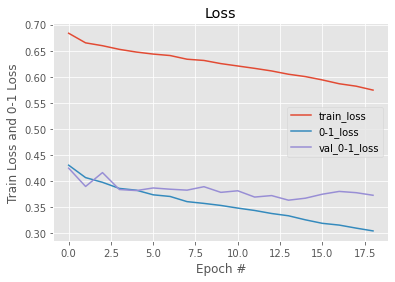

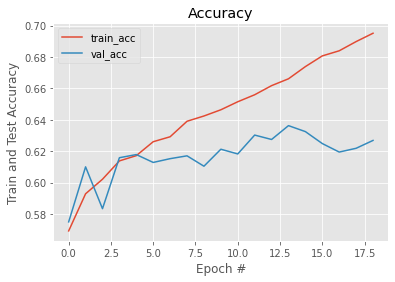

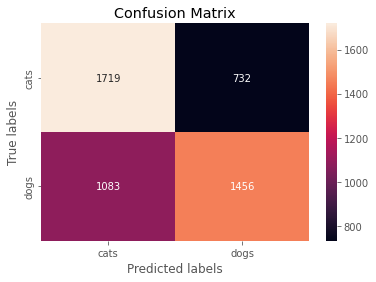

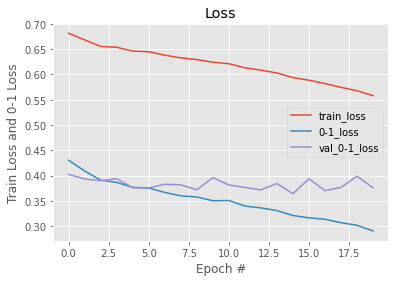

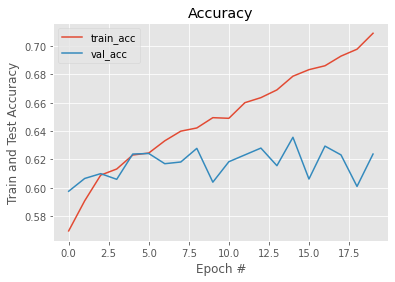

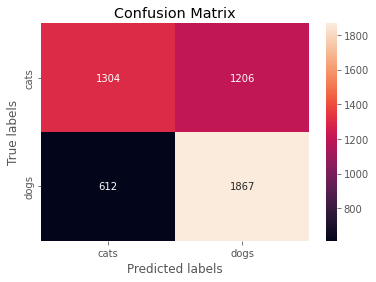

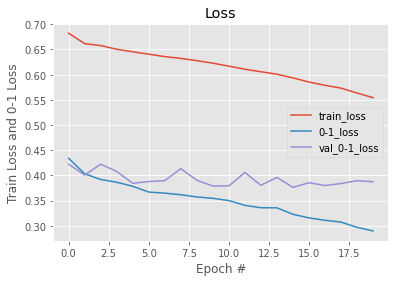

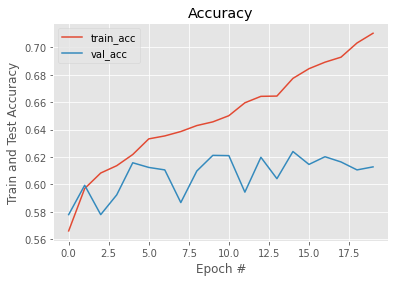

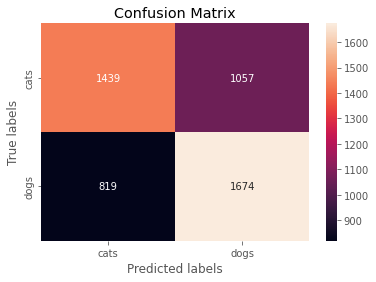

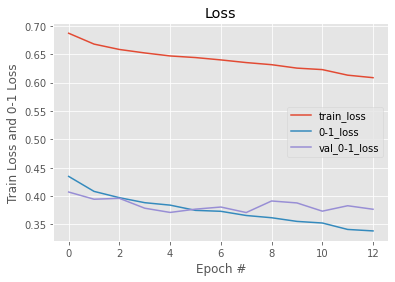

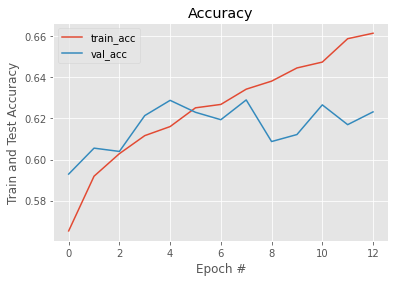

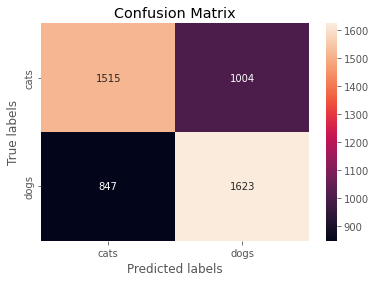

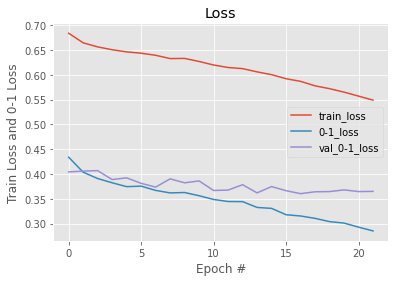

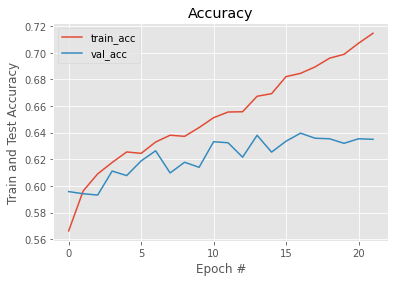

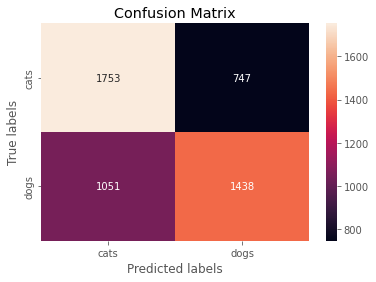

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6454205513000488 - Accuracy: 0.6362725496292114% - Zero-One N Loss: 1815 - Zero-One Loss: 0.3637274549098196%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6552247405052185 - Accuracy: 0.6355983018875122% - Zero-One N Loss: 1818 - Zero-One Loss: 0.36440168370414916%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6492553353309631 - Accuracy: 0.6239727139472961% - Zero-One N Loss: 1876 - Zero-One Loss: 0.3760272599719383%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6487869024276733 - Accuracy: 0.628983736038208% - Zero-One N Loss: 1851 - Zero-One Loss: 0.3710162357185809%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6411421298980713 - Accuracy: 0.6396071314811707% - Zero-One N Loss: 1798 - Zero-One L

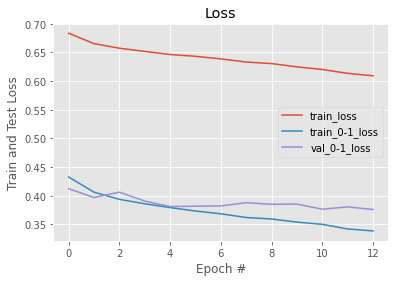

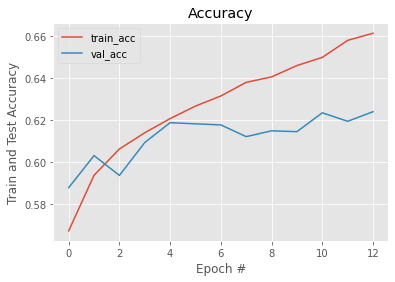

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(30,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(30,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(30,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(30,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(30,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[1546.   949.2]
 [ 882.4 1611.6]]


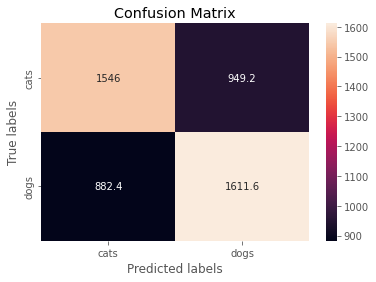

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

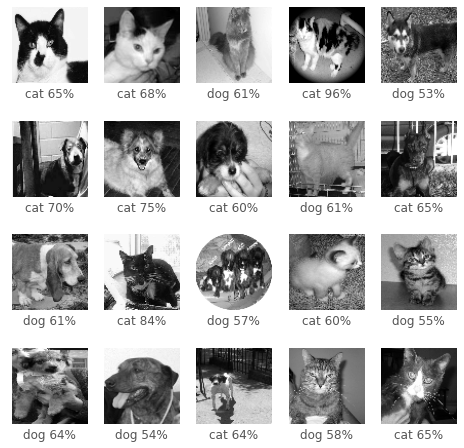

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

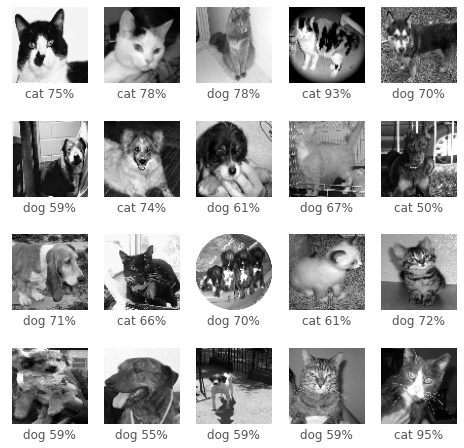

In [ ]:
#[0 1]-> cat,[1 0]->dog
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()